In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from data.fetchdata import getProvinceData, getCountryData


In [97]:
d, con, rec = getProvinceData("浙江省")
#d, con, rec = getCountryData("KR")


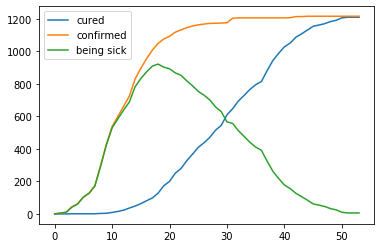

In [98]:
plt.plot(rec, label='cured')
plt.plot(con, label='confirmed')
plt.plot(con-rec, label='being sick')
plt.legend(loc='upper left')


In [166]:
def dataPrepare(total_population, confirmed, recovered, exposed_ratio):
    days = len(confirmed)
    X = []
    y = []
    for i in range(days-2):
        I_0 = confirmed[i]
        R_0 = recovered[i]
        E_0 = I_0 * exposed_ratio
        S_0 = total_population - I_0 - R_0 - E_0
        I_1 = confirmed[i+1]
        R_1 = recovered[i+1]
        E_1 = I_1 * exposed_ratio
        S_1 = total_population - I_1 - R_1 - E_1
        
        X.append([S_0, E_0, I_0, R_0, S_1, E_1, I_1, R_1])
        y.append(confirmed[i+2])
    return np.array(X), np.array(y).reshape((-1,1))

def dataPrepareWithTime(total_population, confirmed, recovered, exposed_ratio):
    days = len(confirmed)
    X = []
    y = []
    for i in range(days-1):
        I = confirmed[i]
        R = recovered[i]
        E = I * exposed_ratio
        S = total_population - I - R - E
        X.append([S, E, I, R, i])
        y.append(confirmed[i+1])
    return np.array(X), np.array(y).reshape((-1,1))

def check_and_plot(X, y, date, params):
    days = X.shape[0]
    predict_infected = []
    for day in range(days):
        data = X[day]
        S_1 = data[4]
        E_1 = data[5]
        I_1 = data[6]
        R_1 = data[7]
        N = S_1 + E_1 + I_1 + R_1
        preS = (1 - params[0]*I_1/N) * S_1
        preE = (1 - params[1])*E_1 + params[0]*I_1*S_1/N
        preI = (1 - params[2])*I_1 + params[1]*E_1
        preR = R_1 + params[2]*I_1
        predict_infected.append(preI)
    plt.figure(figsize=(12,6))
    plt.plot(predict_infected, label="predicted")
    plt.plot(y, label="ground truth")
    plt.legend(loc='upper left')
    date = [d[5:] for d in date]
    plt.xticks(np.arange(days), date)
    plt.show()
    return predict_infected

def predict_and_plot(X, y, date, start_predict, params):
    days = X.shape[0]
    predict_infected = []
    for day in range(start_predict):
        data = X[day]
        S_1 = data[4]
        E_1 = data[5]
        I_1 = data[6]
        R_1 = data[7]
        N = S_1 + E_1 + I_1 + R_1
        preS = (1 - params[0]*I_1/N) * S_1
        preE = (1 - params[1])*E_1 + params[0]*I_1*S_1/N
        preI = (1 - params[2])*I_1 + params[1]*E_1
        preR = R_1 + params[2]*I_1
        predict_infected.append(preI)
        
    S_1 = X[start_predict][4]
    E_1 = X[start_predict][5]
    I_1 = X[start_predict][6]
    R_1 = X[start_predict][7]
    for day in range(start_predict, days):
        N = S_1 + E_1 + I_1 + R_1
        preS = (1 - params[0]*I_1/N) * S_1
        preE = (1 - params[1])*E_1 + params[0]*I_1*S_1/N
        preI = (1 - params[2])*I_1 + params[1]*E_1
        preR = R_1 + params[2]*I_1
        predict_infected.append(preI)
        S_1 = preS
        E_1 = preE
        I_1 = preI
        R_1 = preR
    plt.figure(figsize=(12,6))
    plt.plot(predict_infected, label="predicted")
    plt.plot(y, label="ground truth")
    plt.legend(loc='upper left')
    date = [d[5:] for d in date]
    # plt.xticks(np.arange(days), date)
    plt.xticks(np.arange(days))
    plt.show()
    return predict_infected

In [100]:
province_population = 57000000
X, y = dataPrepare(province_population, con, rec, 4)

In [153]:
X_train = X[:40,:]
y_train = y[:40,:]
d_train = d[:40]

## Static SEIR Model

- $\sigma$: $\frac{1}{incubation time}$ ~ [$\frac{1}{14}$, 1]
- $\gamma$: $\frac{1}{recovery time}$ ~ [$\frac{1}{17+4}$, $\frac{1}{17-4}$]
- $\beta$: $R_0 = \frac{\beta}{\gamma}$, $R_0$ of COVID-19 is around 1.4~3.8, so $\beta$ ~ [0.067, 0.292]

In [77]:
class SSEIR(nn.Module):
    def __init__(self, beta_range, sigma_range, gamma_range):
        super(SSEIR, self).__init__()
        self.betaL = beta_range[0]
        self.betaH = beta_range[1]
        self.sigmaL = sigma_range[0]
        self.sigmaH = sigma_range[1]
        self.gammaL = gamma_range[0]
        self.gammaH = gamma_range[1]
        self.params = torch.tensor([0.17, 0.2, 0.07], dtype=torch.float, requires_grad=True)
    
    def forward(self, X):
        S_0 = X[0]
        E_0 = X[1]
        I_0 = X[2]
        R_0 = X[3]
        S_1 = X[4]
        E_1 = X[5]
        I_1 = X[6]
        R_1 = X[7]
        N = S_0 + E_0 + I_0 + R_0
        preE_1 = (1 - self.params[1])*E_0 + self.params[0]*I_0*S_0/N
    
        preS = (1 - self.params[0]*I_1/N) * S_1
        preE = (1 - self.params[1])*E_1 + self.params[0]*I_1*S_1/N
        preI = (1 - self.params[2])*I_1 + self.params[1]*preE_1
        preR = R_1 + self.params[2]*I_1
        return (preS, preE, preI, preR)

In [154]:
sseir = SSEIR(beta_range=[0.066, 0.292], sigma_range=[1.0/14, 1.0], gamma_range=[1.0/21, 1.0/13])
sseir = sseir.float()

In [155]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([sseir.params], lr=0.0003)

In [156]:
num_epoch = 500
lam0 = 0.2
lam1 = 10000
lam2 = 10000
lam3 = 10000

for epoch in range(num_epoch):
    ids = np.random.permutation(X_train.shape[0])
    epoch_loss = 0.0
    for sample_id in ids:
        currday = torch.from_numpy(X_train[sample_id])
        nextInfected = torch.from_numpy(y_train[sample_id])
        
        optimizer.zero_grad()
        out = sseir(currday.float())
        preInfected = out[2]
        loss = criterion(preInfected, nextInfected.float())
        epoch_loss += loss.item()
        reg = lam1*(F.relu(sseir.params[0]-sseir.betaH) + F.relu(sseir.betaL-sseir.params[0])) \
             +lam2*(F.relu(sseir.params[1]-sseir.sigmaH) + F.relu(sseir.sigmaL-sseir.params[1])) \
             +lam3*(F.relu(sseir.params[2]-sseir.gammaH) + F.relu(sseir.gammaL-sseir.params[2]))
        loss = lam0*loss + (1-lam0)*reg
        # epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print (epoch_loss/len(ids))
    

C:\Users\mbfdc\Anaconda3\envs\work\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


285718.37715349195
249618.56504211426
216363.16394076348
186495.65894655883
158574.47999330852
134493.59165472985
112410.31154828072
93387.88817329406
76833.35041742325
62332.76443319321
50294.373140716554
40148.890585422516
31686.249670219422
24952.2479095459
19435.335058164597
15199.569416256249
11889.855840420723
9370.205134677886
7444.750681495667
6099.82049908638
5137.9246622085575
4455.212862876057
3975.481009888649
3605.589747834206
3357.7386793136598
3190.8728408813477
3071.790540409088
2964.7083776474
2892.446823823452
2850.1722721338274
2822.578914453089
2793.2991829648613
2768.988010966778
2767.9890518307684
2738.9038498163222
2738.1091083288193
2725.843721604347
2719.826761341095
2705.439624810219
2702.9654871463777
2702.6381677150725
2719.08448035717
2696.39858648777
2708.4313269615172
2679.001664066315
2665.5158187627794
2682.3394680023193
2668.241236591339
2662.5461815357207
2665.1582313776016
2653.6298212051393
2661.392157125473
2654.041535615921
2647.0109952926637
2638

2258.3156178325416
2292.5146820127966
2265.2693488717077
2264.7361666321754
2299.8449542004614
2243.0155596509576
2326.9148307025434
2284.848101377487
2248.913238465786
2261.0102152615787
2299.370940301195
2261.9404566247017
2254.6335205629466
2249.712748336792
2266.2925534069536
2282.066810178757
2284.9537717938424
2264.467598727718
2273.3283091843127
2272.210867750645
2293.9887796401977
2275.299486700073
2331.378416004777
2246.646211659908
2295.0267676591875
2265.5327121555806
2242.176004266739
2292.294388499856
2256.564557922259
2306.9145796179773
2256.352125898376
2269.241853070259
2255.0601479291918
2298.6986591100695
2291.033873128891
2246.630533742905
2241.080893480778
2306.3312576983126
2290.863336443901
2284.7402210712435
2297.589369866252
2240.1405754089355
2264.3866207897663
2262.8080096870663
2278.3181285113096
2285.643365496397
2244.069820547104
2261.60371401757
2268.821052056551
2257.6609466806053
2284.8181360721587
2265.115220600739
2265.9077226102354
2305.305973482132
2

In [158]:
sseir.params.detach().numpy()

array([0.0660736 , 0.02531358, 0.07680123], dtype=float32)

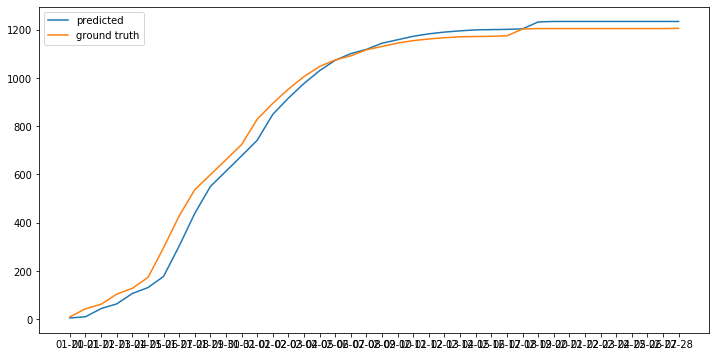

In [159]:
_ = check_and_plot(X_train, y_train, d_train, sseir.params.detach().numpy())

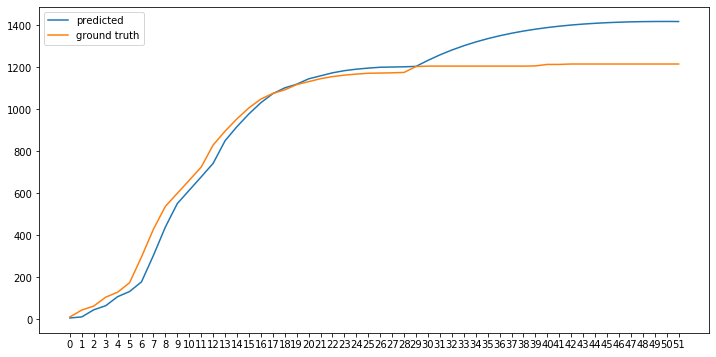

In [162]:
_ = predict_and_plot(X, y, d, 30, sseir.params.detach().numpy())

## Dynamic SEIR Model

In [169]:
province_population = 57000000
X, y = dataPrepareWithTime(province_population, con, rec, 4)

In [172]:
X_train = X[:40,:]
y_train = y[:40,:]
d_train = d[:40]

In [164]:
class DSEIR(nn.Module):
    def __init__(self, beta_C, sigma, gamma):
        super(DSEIR, self).__init__()
        self.sigma = sigma
        self.gamma = gamma
        self.C = beta_C
        self.params = torch.tensor([0., 0.], dtype=torch.float, requires_grad=True)
    
    def computeBeta(self, t):
        return self.C * torch.exp(self.params[0]*(t+self.params[1]))/((1+torch.exp(self.params[0]*(t+self.params[1])))**2)
    
    def forward(self, X):
        S = X[0]
        E = X[1]
        I = X[2]
        R = X[3]
        t = X[4]
        N = S + E + I + R
        preBeta = self.computeBeta(t)
        preS = (1 - preBeta*I/N) * S
        preE = (1 - self.sigma)*E + preBeta*I*S/N
        preI = (1 - self.gamma)*I + self.sigma*E
        preR = R + self.gamma*I
        return (preS, preE, preI, preR)

In [165]:
dseir = DSEIR(beta_C=0.0660736, sigma=0.02531358, gamma=0.07680123)

In [ ]:
num_epoch = 500
lam0 = 0.2
lam1 = 10000
lam2 = 10000
lam3 = 10000

for epoch in range(num_epoch):
    ids = np.random.permutation(X_train.shape[0])
    epoch_loss = 0.0
    for sample_id in ids:
        currday = torch.from_numpy(X_train[sample_id])
        nextInfected = torch.from_numpy(y_train[sample_id])
        
        optimizer.zero_grad()
        out = dseir(currday.float())
        preInfected = out[2]
        loss = criterion(preInfected, nextInfected.float())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print (epoch_loss/len(ids))
    